In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import scipy as sp
import pandas as pd
import re
import os
from importlib import reload
import seaborn as sns
import analise
from analise import ior,find_reports
reload(analise)
reload(ior)

sns.set_style("whitegrid")

/tmp/ipykernel_125596/1649930646.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data=ior.load_reports("../../reports/singleShared").query("op=='write'").sort_values(by="tasks")
data

,op,bandwidth,nodes,tasks,stripes,segments
0,write,1.28166,1,36,8,1
8,write,1.36740,1,36,1,1
6,write,1.33122,1,36,1,1
4,write,1.40990,1,36,1,1
2,write,1.34682,1,36,1,1
...,...,...,...,...,...,...
4,write,1.12160,1,36,8,1000
2,write,1.17890,1,36,8,1000
0,write,1.12133,1,36,8,1000
6,write,1.57574,1,36,1,100


In [3]:
data_agg=ior.aggregate_OST(data).dropna()
data_agg

/mnt/lustre/e1000/home/z04/z04/lparisi/e1000_benchmarking/filesystem_benchmarks/anal/analise/ior.py:67: FutureWarning: The provided callable <function std at 0x7f3852ca6980> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  return data.groupby(["nodes","tasks","op","stripes","segments"]).aggregate(func=[np.average,np.std]).reset_index(drop=False)


nodes tasks     op stripes segments bandwidth          
                                         average       std
0      1    36  write      -1        1  1.323691  0.071642
2      1    36  write      -1     1000  1.281954  0.027816
3      1    36  write       1        1  1.344223  0.052802
4      1    36  write       1       10  1.495617  0.027302
5      1    36  write       1      100  1.570923  0.034554
6      1    36  write       1     1000  1.277124  0.023625
7      1    36  write       4        1  1.310309  0.105279
8      1    36  write       4      100  1.582356  0.046813
9      1    36  write       4     1000  1.136410  0.020197
10     1    36  write       8        1  1.357333  0.044089
11     1    36  write       8      100  1.420144  0.028126
12     1    36  write       8     1000  1.139810  0.027043
13     1    36  write      12        1  1.275770  0.048422
14     1    36  write      12      100  1.445132  0.041162
15     1    36  write      12     1000  1.122928  0.020081
16     1    36  write      16        1  1.493050  0.050065
17     1    36  write      16      100  1.649086  0.059690
18     1    36  write      16     1000  1.133378  0.036374

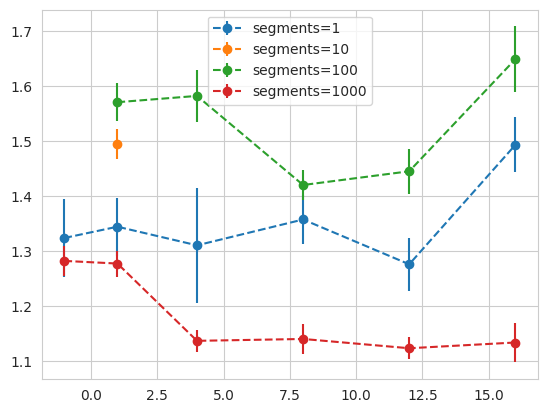

In [4]:
reload(ior)
#ior.scatter_plot_ost(data)
#plt.show()
ior.scatter_plot_ost_aggregated(data_agg,x="stripes",by="segments")
plt.show()

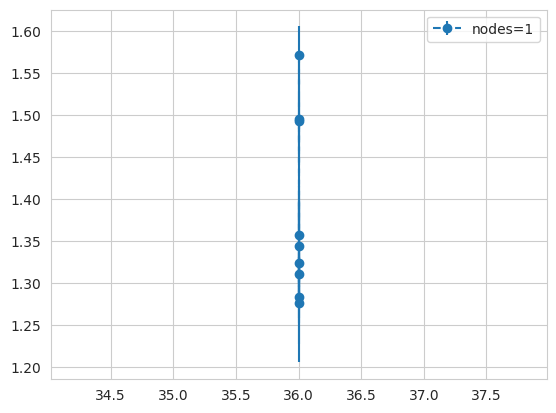

In [35]:

for value,_data in data_agg.sort_values("tasks").groupby("nodes"):
        plt.errorbar( _data.loc[:,"tasks"] , _data.loc[:,('bandwidth', 'average')],_data.loc[:,('bandwidth', 'std')],label=f"nodes={value}",fmt="o--")
plt.legend()

In [473]:
def build_mdtest_pattern():
    pattern_float=r"(\d+(?:\.\d+)?)"
    patter_int=r"(\d+)"
    pattern=r"^\s*File\s+(\w+)"
    for i in range(4):
        pattern=pattern + r"\s+" + pattern_float
    pattern=pattern+r"$"
    return pattern




def load(filename):
    pattern=build_mdtest_pattern()
    data={("operation",""):[],("bandwidth","average"):[],("bandwidth","std"):[]}
    tasks=None
    files=None
    nodes=None
    with open(filename) as f:
        section=None
        for line in f.readlines():

            m=re.match(r"(\d+)\s+tasks,\s+(\d+)\s+files",line.strip())
            if m is not None:
                #print(m)
                tasks=int(m[1])
                files=int(m[2])

            m=re.match(r"nodes: (\d+)",line.strip())
            if m is not None:
                #print(m)
                nodes=int(m[1])
                
            
            m=re.match(r"SUMMARY\s+(\w+)\s+\(in ops\/sec\): \(of\s+(\d+)\s+iterations\)",line.strip())
            if m is not None:
                if m[1]=="rate":
                    section="bandwidth"
                else:
                    section=None
            if section=="bandwidth":
                m=re.match(pattern,line.strip()) 
                if m is not None:
                    data[("operation",'')].append(m[1])
                    data[('bandwidth','average')].append(float(m[4])/1e+3)
                    data[('bandwidth','std')].append(float(m[5])/1e+3)
    data=pd.DataFrame(data)
    data[("nodes","")]=nodes
    data[("tasks","")]=tasks
    data[("files","")]=files

    return data

def load_reports(directoryname):
    
    return pd.concat([pd.DataFrame(load(filename)) for filename in find_reports(directoryname)])

In [466]:
filename="../results/archer2-work4/md_easy_onOST/report-md-4N-128cpN-nf10000-2024-02-16-17.10.14.txt"
load(filename)

operation  bandwidth           nodes tasks files
               average       std                  
0  creation  48.030303  4.359896     4   512  9728
1      stat  97.087567  1.300584     4   512  9728
2      read  71.503236  7.852856     4   512  9728
3   removal  24.782461  1.368758     4   512  9728

In [477]:
data=load_reports("../results/archer2-work4/md_hard//")
data=data[(data["nodes"]==4) & (data["files"]>0)]
data

operation   bandwidth      nodes tasks   files
                average  std                    
0  creation    6.735260  0.0     4   512     512
1      stat   10.894794  0.0     4   512     512
2      read   10.751772  0.0     4   512     512
3   removal    7.055341  0.0     4   512     512
0  creation    3.417107  0.0     4   512    9728
1      stat   85.371659  0.0     4   512    9728
2      read   62.563540  0.0     4   512    9728
3   removal    7.113185  0.0     4   512    9728
0  creation    3.064745  0.0     4     4  100000
1      stat    9.042098  0.0     4     4  100000
2      read    3.216993  0.0     4     4  100000
3   removal    7.747233  0.0     4     4  100000
0  creation    6.396203  0.0     4   256   99840
1      stat  119.814353  0.0     4   256   99840
2      read   69.810473  0.0     4   256   99840
3   removal    6.814314  0.0     4   256   99840
0  creation    2.278678  0.0     4   256    9984
1      stat   88.512975  0.0     4   256    9984
2      read   56.429036  0.0     4   256    9984
3   removal    7.682818  0.0     4   256    9984
0  creation    7.068634  0.0     4   128    9984
1      stat  101.629756  0.0     4   128    9984
2      read   54.644277  0.0     4   128    9984
3   removal    7.951393  0.0     4   128    9984
0  creation    2.164333  0.0     4     4    1000
1      stat    6.289349  0.0     4     4    1000
2      read    1.801217  0.0     4     4    1000
3   removal    6.981431  0.0     4     4    1000
0  creation    7.937005  0.0     4   256     768
1      stat   29.286264  0.0     4   256     768
2      read   17.455716  0.0     4   256     768
3   removal    7.798614  0.0     4   256     768
0  creation    7.251009  0.0     4   128     896
1      stat   48.537285  0.0     4   128     896
2      read   17.541443  0.0     4   128     896
3   removal    8.099223  0.0     4   128     896
0  creation    2.162374  0.0     4     4   10000
1      stat    6.829626  0.0     4     4   10000
2      read    2.146422  0.0     4     4   10000
3   removal    7.838771  0.0     4     4   10000
0  creation    8.652255  0.0     4   128   99968
1      stat  122.609899  0.0     4   128   99968
2      read   61.014548  0.0     4   128   99968
3   removal    6.923647  0.0     4   128   99968
0  creation    7.699181  0.0     4   512   99840
1      stat  137.014089  0.0     4   512   99840
2      read   72.005343  0.0     4   512   99840
3   removal    6.764601  0.0     4   512   99840
0  creation    1.042143  0.0     4     4     100
1      stat    4.874717  0.0     4     4     100
2      read    1.086331  0.0     4     4     100
3   removal    4.449387  0.0     4     4     100

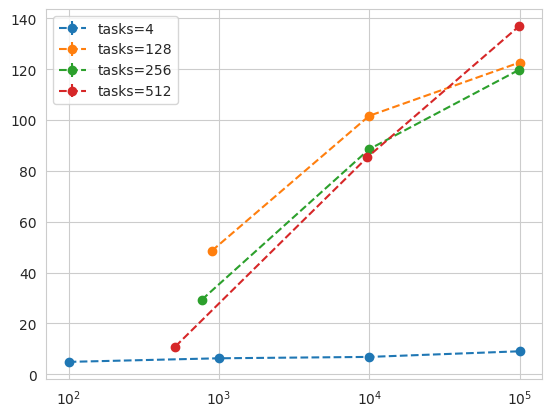

In [479]:
fig,ax=plt.subplots()
for value,_data in data[data["operation"]=="stat"  ].sort_values("files").dropna().groupby("tasks"):
    plt.errorbar(_data[("files",'')],_data[("bandwidth","average")],_data[("bandwidth","std")],label=f"tasks={value}",fmt="o--")
plt.legend()
plt.xscale("log")